# Duplicate Real Estate Listings 

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from tqdm import tqdm
import os
import uuid
import matplotlib.pyplot as plt
import hashlib
from PIL import Image
import requests
from io import BytesIO
import glob
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme({
    "valid": "bold green encircle",
    "info": "dim cyan",
    "warning": "magenta",
    "danger": "bold red"
})
test_theme={
    True:"valid",
    False:"danger",
}
console = Console(theme=custom_theme)


pd.options.display.max_rows=50
pd.options.display.max_columns=90
df = pd.read_csv("data/Dataset - Ads _ Levallois-Perret - 2019-08 - export-ads-levallois-perret-2019-08-27.csv")

## EDA : Explaratory Data Analysis

### i. Data exploration

In [55]:
for type in df.dtypes.unique():
    same_dtype_columns = df.select_dtypes(include=type).columns
    console.print(f"\n[bold]Data type[/bold] : {type} \n[bold]Columns[/bold] : {list(same_dtype_columns)} \n")

Data type : object 
Columns : ['ID', 'URL', 'CRAWL_SOURCE', 'PROPERTY_TYPE', 'NEW_BUILD', 'DESCRIPTION', 'IMAGES', 'FURNISHED', 
'HEATING_TYPES', 'HEATING_MODE', 'ELEVATOR', 'CARETAKER', 'MARKETING_TYPE', 'PRICE_EVENTS', 
'RENTAL_EXPENSES_INCLUDED', 'FEES_INCLUDED', 'AGENCIES_UNWANTED', 'OCCUPIED', 'DEALER_NAME', 'DEALER_TYPE', 'CITY',
'PUBLICATION_START_DATE', 'LAST_CRAWL_DATE', 'LAST_PRICE_DECREASE_DATE']

Data type : float64 
Columns : ['SURFACE', 'LAND_SURFACE', 'BALCONY_SURFACE', 'TERRACE_SURFACE', 'ROOM_COUNT', 'BEDROOM_COUNT', 
'BATHROOM_COUNT', 'LUNCHROOM_COUNT', 'TOILET_COUNT', 'FIREPLACE', 'AIR_CONDITIONING', 'GARDEN', 'SWIMMING_POOL', 
'BALCONY', 'TERRACE', 'CELLAR', 'PARKING_COUNT', 'FLOOR', 'FLOOR_COUNT', 'CONSTRUCTION_YEAR', 'ENERGY_CONSUMPTION',
'GREENHOUSE_GAS_CONSUMPTION', 'PRICE', 'PRICE_M2', 'RENTAL_EXPENSES', 'DEPOSIT', 'FEES', 'ZIP_CODE', 
'PUBLICATION_END_DATE']

Data type : bool 
Columns : ['PARKING', 'EXCLUSIVE_MANDATE']

Data type : int64 
Columns : ['CITY_ID', 'DEPT_CODE']

In [56]:
def style_max(v, props=''):
    return props if v==100 else None

def show_na(df):
    na_cols = (pd.Series(df.isna().sum()/len(df.index)*100).reset_index().
        rename(columns={'index':'Feature',0:'Missing_Values'}).
        sort_values(by=['Missing_Values'], ascending=[False]))
    na_cols["Missing_Values"] = na_cols.apply(lambda row: round(row["Missing_Values"],2), axis=1)
    na_cols=na_cols[na_cols["Missing_Values"]>0]
    na_cols = na_cols.set_index('Feature')

    return na_cols

cm = sns.light_palette("red", as_cmap=True)

nas_stat = show_na(df)
nas_stat.style.set_caption("Pourcentage of missing values for each Feauture in the dataset")\
              .background_gradient(cmap=cm).applymap(style_max, props='color:black;')


,Missing_Values
Feature,
TOILET_COUNT,100.000000
GREENHOUSE_GAS_CONSUMPTION,100.000000
PUBLICATION_END_DATE,100.000000
AIR_CONDITIONING,100.000000
FIREPLACE,100.000000
CELLAR,100.000000
LUNCHROOM_COUNT,100.000000
BATHROOM_COUNT,100.000000
BALCONY_SURFACE,100.000000


In [57]:
empty_columns = nas_stat[nas_stat["Missing_Values"]==100].index
df.drop(columns=empty_columns, inplace=True)

In [58]:

def style_unique(v, props='', n=2164):
    return props if v==n else None

def style_constant(v, props=''):
    return props if v==1 else None

def show_card(df):
    df = (pd.Series({feature: len(df[feature].unique()) for feature in df.columns})
                        .reset_index().rename(columns={'index':'Feature',0:'Cardinality'}))
    df =df.set_index('Feature')
    return df.sort_values(by ='Cardinality', ascending=False )

card_stat = show_card(df)
card_stat.style.set_caption("Cardinality of each feature in the dataset").applymap(style_constant, props='background-color:red;color:white')\
    .applymap(style_unique, props='background-color:green;color:white', n=len(df))

,Cardinality
Feature,
ID,2164
URL,2164
LAST_CRAWL_DATE,2164
PUBLICATION_START_DATE,2103
IMAGES,1947
DESCRIPTION,1915
PRICE_EVENTS,1733
PRICE_M2,998
PRICE,765


In [59]:
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

In [60]:
def generate_unique_identifier(input_string):
    # Using SHA256 as the hashing algorithm
    hash_object = hashlib.sha256(input_string.encode())
    unique_identifier = hash_object.hexdigest()
    return unique_identifier

def download_df_images_locally(df, images_column_name = "IMAGES", id_column_name = "ID", export_path ="data/images/" ):

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):

        # parsing the array
        array_urls = json.loads(row[images_column_name])


        directory = f"{export_path}{row[id_column_name]}"

        if not os.path.exists(directory):
            os.makedirs(directory)

        # downloading the images
        for j, url in enumerate(array_urls):
            try : 
                img_name = generate_unique_identifier(url)
                save_image_path = f"{directory}/{img_name}.png"
                if os.path.exists(save_image_path):
                    continue
                else:
                    img = download_image(url)
                    img.save(save_image_path)                
            except Exception as e :
                continue
    



In [61]:
# download_df_images_locally(df)

### ii. dataset cleaning

In [62]:
## Droping constant columns : 

In [63]:
df.drop(columns = ["CITY_ID", "CITY", "DEPT_CODE"], axis=1, inplace=True)

In [64]:
## Parsing Heating Types

In [65]:
heating_types = []
for value in df["HEATING_TYPES"].unique():
    heating_array = json.loads(value)
    heating_types.extend(heating_array)
print("Unique Heating Types are : ", heating_types)
def parse_heating_type(row, heating_types):
    for heating_type in heating_types:
        if heating_type in row["HEATING_TYPES"]:
            row[heating_type]=1
        else:
            row[heating_type]=0
    return row
df = df.apply(lambda row : parse_heating_type(row, heating_types=heating_types), axis=1)

Unique Heating Types are :  ['ELECTRIC', 'GAS', 'ELECTRIC', 'UNDERFLOOR', 'FUEL']


In [66]:
## Adding the number of listed images and number of downloaded images

In [67]:
def count_urls(urls):
    array_urls = json.loads(urls)
    return len(array_urls)

def count_images(id, data_path = "data/images/"):
    
    list_images = glob.glob( f"{data_path}{id}/*png")
    return len(list_images)

df["NUMBER_URL_IMAGES"]=df.apply(lambda row : count_urls(row["IMAGES"]), axis = 1)
df["NUMBER_VALID_IMAGES"]=df.apply(lambda row : count_images(row["ID"]), axis = 1)

In [68]:
## Fixing bad datatypes
def describe_features(df, features):
    for feature in features :
        console.print(f"Unique Values for    [bold cyan]{feature}[/ bold cyan] : ", df[feature].unique())
        console.print(f"Number of offers with [bold cyan]{feature}[/ bold cyan] : ", df[feature].sum())
bool_columns = ["SWIMMING_POOL", "NEW_BUILD", "FURNISHED", "GARDEN", "PARKING", "TERRACE", "PARKING", "ELEVATOR", "CARETAKER", "RENTAL_EXPENSES_INCLUDED", "EXCLUSIVE_MANDATE", "AGENCIES_UNWANTED", "OCCUPIED"]

describe_features(df,bool_columns)
# To note : TERRACE, SWIMMING_POOL & GARDEN only have nan, and 1 as unique values

Unique Values for    SWIMMING_POOL :  [nan  1.]

Number of offers with SWIMMING_POOL :  6.0

Unique Values for    NEW_BUILD :  [False nan True]

Number of offers with NEW_BUILD :  103

Unique Values for    FURNISHED :  [False nan True]

Number of offers with FURNISHED :  213

Unique Values for    GARDEN :  [nan  1.]

Number of offers with GARDEN :  14.0

Unique Values for    PARKING :  [ True False]

Number of offers with PARKING :  157

Unique Values for    TERRACE :  [nan  1.]

Number of offers with TERRACE :  86.0

Unique Values for    PARKING :  [ True False]

Number of offers with PARKING :  157

Unique Values for    ELEVATOR :  [True nan False]

Number of offers with ELEVATOR :  507

Unique Values for    CARETAKER :  [nan False True]

Number of offers with CARETAKER :  147

Unique Values for    RENTAL_EXPENSES_INCLUDED :  [True nan False]

Number of offers with RENTAL_EXPENSES_INCLUDED :  578

Unique Values for    EXCLUSIVE_MANDATE :  [False  True]

Number of offers with EXCLUSIVE_MANDATE :  167

Unique Values for    AGENCIES_UNWANTED :  [nan False True]

Number of offers with AGENCIES_UNWANTED :  12

Unique Values for    OCCUPIED :  [nan False True]

Number of offers with OCCUPIED :  20

In [69]:
## Replacing NaN value with -1
df = df.fillna(-1)

In [70]:
# Casting bool columns to integer
for col in bool_columns:
    df[col]=df[col].astype(int)

In [71]:
console.print("Unique values for : LAST_PRICE_DECREASE_DATE", df['LAST_PRICE_DECREASE_DATE'].unique())
console.print(f"Dtype is [blue]{df['LAST_PRICE_DECREASE_DATE'].dtype}  [/blue]")

Unique values for : LAST_PRICE_DECREASE_DATE [-1 '2018-09-25' '2019-06-14' '2019-07-10' '2019-07-13' '2019-07-17'
 '2017-05-04' '2019-07-18' '2019-07-19' '2019-07-31' '2019-04-30'
 '2019-06-29' '2019-07-30' '2019-06-17' '2018-01-30' '2019-07-15'
 '2019-08-09' '2019-03-17' '2019-06-13' '2019-04-25' '2019-06-15'
 '2019-07-12' '2019-08-17' '2019-06-26' '2019-06-28' '2019-03-29'
 '2019-07-23' '2019-07-08' '2019-04-02' '2019-05-30' '2019-02-14'
 '2019-06-21' '2019-08-21' '2019-04-16' '2019-06-20' '2019-06-04'
 '2019-07-20' '2019-08-25' '2019-05-11' '2019-05-21' '2019-05-08'
 '2019-05-29' '2019-07-27' '2019-07-07' '2019-02-28' '2019-06-23'
 '2017-05-19' '2019-05-19' '2019-05-06' '2019-06-27' '2019-01-02'
 '2018-12-18' '2019-07-01' '2019-03-20' '2019-07-03' '2019-08-14'
 '2019-08-15' '2019-06-10' '2019-08-08' '2019-07-14' '2019-06-07'
 '2019-04-21' '2017-12-27' '2019-06-22' '2019-08-24' '2019-06-24'
 '2019-06-25' '2019-04-07' '2019-08-07' '2019-08-23' '2019-07-05'
 '2019-04-04' '2019-05-24' '2019-04-23' '2019-08-05' '2019-04-29'
 '2019-06-30' '2017-04-11' '2017-11-20' '2017-03-22' '2019-05-27'
 '2019-06-05' '2019-04-01' '2019-03-13' '2018-10-27' '2017-06-02'
 '2018-08-31' '2019-04-20' '2019-06-08' '2019-02-01' '2019-01-08'
 '2019-07-06' '2019-07-22' '2019-07-24' '2019-03-19' '2019-07-09'
 '2019-04-09' '2019-06-18' '2019-04-05' '2019-07-25' '2019-05-09'
 '2019-01-09' '2019-08-27' '2019-07-29' '2018-03-23' '2019-04-26'
 '2018-04-29' '2018-03-17' '2019-05-07' '2019-05-22' '2019-08-10'
 '2019-04-11' '2019-05-28' '2019-07-21' '2019-04-17' '2018-11-06'
 '2019-07-02' '2019-07-11' '2019-08-02' '2019-01-24' '2019-04-06'
 '2019-06-11' '2018-06-01' '2018-10-17' '2019-02-19' '2017-03-09'
 '2019-06-06' '2017-02-03' '2019-04-12' '2017-07-27' '2019-05-15'
 '2018-05-22' '2019-08-13' '2018-07-19' '2019-06-12' '2019-08-22'
 '2018-11-26' '2018-12-19' '2019-07-26' '2019-03-21' '2019-05-04'
 '2019-07-16' '2019-08-06' '2019-03-22' '2018-01-12' '2019-08-03']

Dtype is object  

In [72]:
# Convert string to a date format
df['LAST_PRICE_DECREASE_DATE'] = pd.to_datetime(df['LAST_PRICE_DECREASE_DATE'])
df['LAST_CRAWL_DATE'] = pd.to_datetime(df['LAST_CRAWL_DATE'], format='mixed')
df['PUBLICATION_START_DATE'] = pd.to_datetime(df['PUBLICATION_START_DATE'], format='mixed')

df['LAST_PRICE_DECREASE_DATE'].head(2)
# Note : 1969-12-31 23:59:59.999999999 Stands for NaN

0   1969-12-31 23:59:59.999999999
1   2018-09-25 00:00:00.000000000
Name: LAST_PRICE_DECREASE_DATE, dtype: datetime64[ns]

In [73]:
# replacing -1 with None for string columns
string_columns = ["CRAWL_SOURCE", "PROPERTY_TYPE", "DESCRIPTION", "HEATING_TYPES", "HEATING_MODE", "MARKETING_TYPE", "DEALER_NAME", "DEALER_TYPE"]
for col in string_columns:
    df[col]=df[col].replace(-1, "None")

In [74]:
df.dtypes

ID                                  object
URL                                 object
CRAWL_SOURCE                        object
PROPERTY_TYPE                       object
NEW_BUILD                            int64
DESCRIPTION                         object
IMAGES                              object
SURFACE                            float64
LAND_SURFACE                       float64
TERRACE_SURFACE                    float64
ROOM_COUNT                         float64
BEDROOM_COUNT                      float64
FURNISHED                            int64
GARDEN                               int64
SWIMMING_POOL                        int64
TERRACE                              int64
PARKING                              int64
PARKING_COUNT                      float64
HEATING_TYPES                       object
HEATING_MODE                        object
FLOOR                              float64
FLOOR_COUNT                        float64
CONSTRUCTION_YEAR                  float64
ELEVATOR   

### iii. Dataset validation

In [75]:
import pytest 
import ipytest 
ipytest.config.rewrite_asserts=True 
__file___='notebook.ipynb'

In [76]:
df_test = df.copy()


@pytest.mark.parametrize("df", [df_test])
def test_df_empty_rows(df):
    value=df.isna().all(axis=1).sum()
    console.print(f"There are : {value} empty rows",style=test_theme[value==0] )
    assert value==0

@pytest.mark.parametrize("df", [df_test])
def test_df_uniqueess(df):
    df["IMAGES"]=df["IMAGES"].apply(lambda v:str(v))
    value = df.duplicated().sum()
    console.print(f"There are : {value} duplicate rows", style=test_theme[value==0] )
    assert value==0

@pytest.mark.parametrize("df", [df_test])
def test_url_uniqueness(df):
    value = len(df["URL"].unique())/len(df)
    console.print(f"There are : {len(df)-len(df['URL'].unique())} duplicate offer URLS", style=test_theme[value==1] )
    assert value ==1

@pytest.mark.parametrize("df", [df_test])
def test_id_uniqueness(df):
    value = len(df["ID"].unique())/len(df)
    console.print(f"There are : {len(df)-len(df['ID'].unique())} duplicate IDS",style=test_theme[value==1] )
    assert value==1

@pytest.mark.parametrize("df", [df_test])
def test_duplicate_descriptions(df):
    value = df["DESCRIPTION"].duplicated().sum()
    console.print(f"There are : {df['DESCRIPTION'].duplicated().sum()} duplicate Descriptions", style=test_theme[value==0] )
    assert value==0

@pytest.mark.parametrize("df", [df_test])
def test_duplicate_price_events(df):
    value = df["PRICE_EVENTS"].duplicated().sum()
    console.print(f"There are : {df['PRICE_EVENTS'].duplicated().sum()} duplicate PRICE_EVENTS",style=test_theme[value==0] )
    assert value==0
    
@pytest.mark.parametrize("df", [df_test])
def test_duplicate_publication_start_date(df):
    value = df['PUBLICATION_START_DATE'].duplicated().sum()
    console.print(f"There are : {value} duplicate PUBLICATION_START_DATE" ,style=test_theme[value==0] )
    assert value==0
    
@pytest.mark.parametrize("df", [df_test])
def test_duplicate_images_url_same_rows(df):
    # Create an empty list to store duplicated URLs
    duplicated_urls = []

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        # Extract the list of URLs from the row
        url_list = json.loads(row['IMAGES'])

        # Check for duplicate URLs within the list
        if len(url_list) != len(set(url_list)):

            # Append the row index to the duplicated_urls list
            duplicated_urls.append(index)
            
    value = len(duplicated_urls)
    console.print(f"There are {value} with duplicate instances of images url",style=test_theme[value==0] )
    assert value==0

@pytest.mark.parametrize("df", [df_test])
def test_url_validity(df):
    invalid = df["NUMBER_URL_IMAGES"].sum()-df["NUMBER_VALID_IMAGES"].sum()
    percent=100*invalid/df["NUMBER_URL_IMAGES"].sum()
    console.print(f"There are : {invalid} invalid Image URLS ({percent:.2f}%)" )
    assert invalid==0


In [ ]:
ipytest.run("-s", "--capture=no", "--tb=no", "-v")

======================================= test session starts ========================================
platform linux -- Python 3.8.16, pytest-7.3.2, pluggy-1.0.0 -- /home/odeck/miniconda3/envs/duplicate/bin/python
cachedir: .pytest_cache
rootdir: /home/odeck/Desktop/duplicate-ads
plugins: anyio-3.5.0
collecting ... collected 9 items

t_93ccc1307dc44ec79b9accb47c4f78e6.py::test_df_empty_rows[df0] 

There are : 0 empty rows

PASSED
t_93ccc1307dc44ec79b9accb47c4f78e6.py::test_df_uniqueess[df0] 

There are : 0 duplicate rows

PASSED
t_93ccc1307dc44ec79b9accb47c4f78e6.py::test_url_uniqueness[df0] 

There are : 0 duplicate offer URLS

PASSED
t_93ccc1307dc44ec79b9accb47c4f78e6.py::test_id_uniqueness[df0] 

There are : 0 duplicate IDS

PASSED
t_93ccc1307dc44ec79b9accb47c4f78e6.py::test_duplicate_descriptions[df0] 

There are : 249 duplicate Descriptions

FAILED
t_93ccc1307dc44ec79b9accb47c4f78e6.py::test_duplicate_price_events[df0] 

There are : 431 duplicate PRICE_EVENTS

FAILED
t_93ccc1307dc44ec79b9accb47c4f78e6.py::test_duplicate_publication_start_date[df0] 

There are : 61 duplicate PUBLICATION_START_DATE

FAILED
t_93ccc1307dc44ec79b9accb47c4f78e6.py::test_duplicate_images_url_same_rows[df0] 

There are 16 with duplicate instances of images url

FAILED
t_93ccc1307dc44ec79b9accb47c4f78e6.py::test_url_validity[df0] 

There are : 3902 invalid Image URLS (31.01%)

FAILED

========================================= warnings summary =========================================
../../miniconda3/envs/duplicate/lib/python3.8/site-packages/_pytest/cacheprovider.py:433
  /home/odeck/miniconda3/envs/duplicate/lib/python3.8/site-packages/_pytest/cacheprovider.py:433: PytestCacheWarning: cache could not write path /home/odeck/Desktop/duplicate-ads/.pytest_cache/v/cache/nodeids
    config.cache.set("cache/nodeids", sorted(self.cached_nodeids))

../../miniconda3/envs/duplicate/lib/python3.8/site-packages/_pytest/cacheprovider.py:387
  /home/odeck/miniconda3/envs/duplicate/lib/python3.8/site-packages/_pytest/cacheprovider.py:387: PytestCacheWarning: cache could not write path /home/odeck/Desktop/duplicate-ads/.pytest_cache/v/cache/lastfailed
    config.cache.set("cache/lastfailed", self.lastfailed)

../../miniconda3/envs/duplicate/lib/python3.8/site-packages/_pytest/stepwise.py:56
  /home/odeck/miniconda3/envs/duplicate/lib/python3.8/site-packages/_pytest/stepwi

<ExitCode.TESTS_FAILED: 1>

In [ ]:
# Droping unused/non-useful columns 

In [77]:
drop_columns = ["URL", "IMAGES", "HEATING_TYPES", "ZIP_CODE"] # There is only one row with NaN ZIP Code
df.drop(columns = drop_columns, inplace=True)

## 1. preparing the dataset :

A perfect solution to this problem would be to embed each offer into a an abstract space where each point or instance is a numerical representation of an offer. Then we can define a distance over such space. Duplicate offers or ads are the instances that have a `distance = 0` between each other. The main issue here is that two duplicate offers can have a `distance > 0`. For example, a user can post the same offer on two sites `bienici` and `leboncoin`. But post different number of pictures, or slightly change the description, add more info, etc between each site.

To solve this issue we'll try to solve this problem by two methods :

- Textual representation
- Image embeddings


####  Edge cases to look out for :

- Duplicate images of logos / Empty images / Floor plans
- Offer for rent and offer for sale at the same time can be counted as duplicates
- Information mismatch between duplicate offers in two different sites or posts

In [78]:
import fiftyone as fo
from tqdm import tqdm
import pandas as pd
import glob
import fiftyone.brain as fob
import fiftyone.core.utils as fou
from collections import Counter
from fiftyone import ViewField as F

In [79]:
def prepare_fiftyone_dataset(df):

    # Create samples for our data
    samples = []
    for i, row in tqdm(df.iterrows(), total=len(df)):

        id_annonce= row["ID"]
        filepaths = glob.glob(f"data/images/{id_annonce}/*.png")

        # Instances that have images 
        if(len(filepaths)>0):
            for j,filepath in enumerate(filepaths) :
                sample = fo.Sample(filepath=filepath)

                # computing hash for individual images
                sample["file_hash"] = fou.compute_filehash(sample.filepath)

                for key in row.keys():
                    sample[key]=row[key]

                samples.append(sample)
    return samples


In [80]:
samples = prepare_fiftyone_dataset(df)

100%|██████████| 2164/2164 [00:05<00:00, 412.46it/s]


In [81]:
dataset = fo.Dataset("Dataset-sms")
dataset.add_samples(samples)
dataset.compute_metadata()

 100% |███████████████| 8682/8682 [4.9s elapsed, 0s remaining, 2.1K samples/s]        
Computing metadata...
  52% |███████|-------| 4517/8682 [39.5s elapsed, 30.6s remaining, 165.5 samples/s]  

In [ ]:
dataset

Name:        Dataset-ss
Media type:  image
Num samples: 64
Persistent:  False
Tags:        []
Sample fields:
    id:                       fiftyone.core.fields.ObjectIdField
    filepath:                 fiftyone.core.fields.StringField
    tags:                     fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                 fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    file_hash:                fiftyone.core.fields.IntField
    ID:                       fiftyone.core.fields.StringField
    URL:                      fiftyone.core.fields.StringField
    CRAWL_SOURCE:             fiftyone.core.fields.StringField
    PROPERTY_TYPE:            fiftyone.core.fields.StringField
    NEW_BUILD:                fiftyone.core.fields.IntField
    DESCRIPTION:              fiftyone.core.fields.StringField
    IMAGES:                   fiftyone.core.fields.StringField
    SURFACE:                  fiftyone.core.fields.FloatFie

In [ ]:
# Define some interesting plots
plot1 = fo.NumericalHistogram(F("metadata.size_bytes") / 1024, bins=50, xlabel="image size (KB)")


In [ ]:
plot2 = fo.NumericalHistogram("predictions.detections.confidence", bins=50, range=[0, 1])
plot3 = fo.CategoricalHistogram("ground_truth.detections.label", order="frequency")
plot4 = fo.CategoricalHistogram("predictions.detections.label", order="frequency")

In [ ]:
plots = [plot1, plot2, plot3, plot4]
plot = fo.ViewGrid(plots)
plot.show(height=720)
# plot.save("./histogram.jpg", scale=2.0)



In [ ]:
session = fo.launch_app(dataset)

In [ ]:
results = fob.compute_uniqueness(dataset)
plot = results.visualize(labels="uniqueness", axis_equal=True)
# plot.save("./embeddings.png", height=300, width=800)
# figure = results.plot_confusion_matrix(
#     classes=classes, backend="matplotlib", figsize=(10, 10)
# )
# plt.show(block=False)


Computing embeddings...


/home/odeck/miniconda3/envs/duplicate/lib/python3.8/site-packages/fiftyone/utils/torch.py:691: RuntimeWarning: overflow encountered in exp
  odds = np.exp(logits)
/home/odeck/miniconda3/envs/duplicate/lib/python3.8/site-packages/fiftyone/utils/torch.py:692: RuntimeWarning: invalid value encountered in divide
  odds /= np.sum(odds, axis=1, keepdims=True)


Computing uniqueness...
Uniqueness computation complete


In [ ]:

# loading the images
subset = 100
size = (200, 200)
embeddings = []
for f in tqdm(dataset.values("filepath")[:subset]) : 
    emb =  Image.open(f).resize(size) # resizing the images 
    embeddings.append(np.array(emb).ravel())

embeddings=np.array(embeddings)
print(embeddings.shape)

# Compute 2D representation
results = fob.compute_visualization(
    dataset[:subset],
    embeddings=embeddings,
    num_dims=2,
    method="umap", # Uniform Manifold Approximation and Projection for Dimension Reduction
    brain_key="umap_embeds",
    verbose=True,
    seed=51,
)

# Compute 2D embeddings
results = fob.compute_visualization(dataset[:subset], embeddings=embeddings, seed=51)

# Visualize embeddings, colored by ground truth label
plot = results.visualize() # label = ""
session.plots.attach(plot)
plot.show(height=720)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 72.78it/s]

(100, 120000)
Generating visualization...


UMAP(random_state=51, verbose=True)
Sun Jun 11 20:07:12 2023 Construct fuzzy simplicial set
Sun Jun 11 20:07:12 2023 Finding Nearest Neighbors
Sun Jun 11 20:07:12 2023 Finished Nearest Neighbor Search
Sun Jun 11 20:07:12 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jun 11 20:07:13 2023 Finished embedding
Generating visualization...
UMAP(random_state=51, verbose=True)
Sun Jun 11 20:07:13 2023 Construct fuzzy simplicial set
Sun Jun 11 20:07:13 2023 Finding Nearest Neighbors
Sun Jun 11 20:07:13 2023 Finished Nearest Neighbor Search
Sun Jun 11 20:07:13 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jun 11 20:07:14 2023 Finished embedding


FigureWidget({
    'data': [{'customdata': array(['64860c759ffa15e51f921e5f', '64860c759ffa15e51f921e60',
                                   '64860c759ffa15e51f921e61', '64860c759ffa15e51f921e62',
                                   '64860c759ffa15e51f921e63', '64860c759ffa15e51f921e64',
                                   '64860c759ffa15e51f921e65', '64860c759ffa15e51f921e66',
                                   '64860c759ffa15e51f921e67', '64860c759ffa15e51f921e68',
                                   '64860c759ffa15e51f921e69', '64860c759ffa15e51f921e6a',
                                   '64860c759ffa15e51f921e6b', '64860c759ffa15e51f921e6c',
                                   '64860c759ffa15e51f921e6d', '64860c759ffa15e51f921e6e',
                                   '64860c759ffa15e51f921e6f', '64860c759ffa15e51f921e70',
                                   '64860c759ffa15e51f921e71', '64860c759ffa15e51f921e72',
                                   '64860c759ffa15e51f921e73', '64860c759ff


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 s


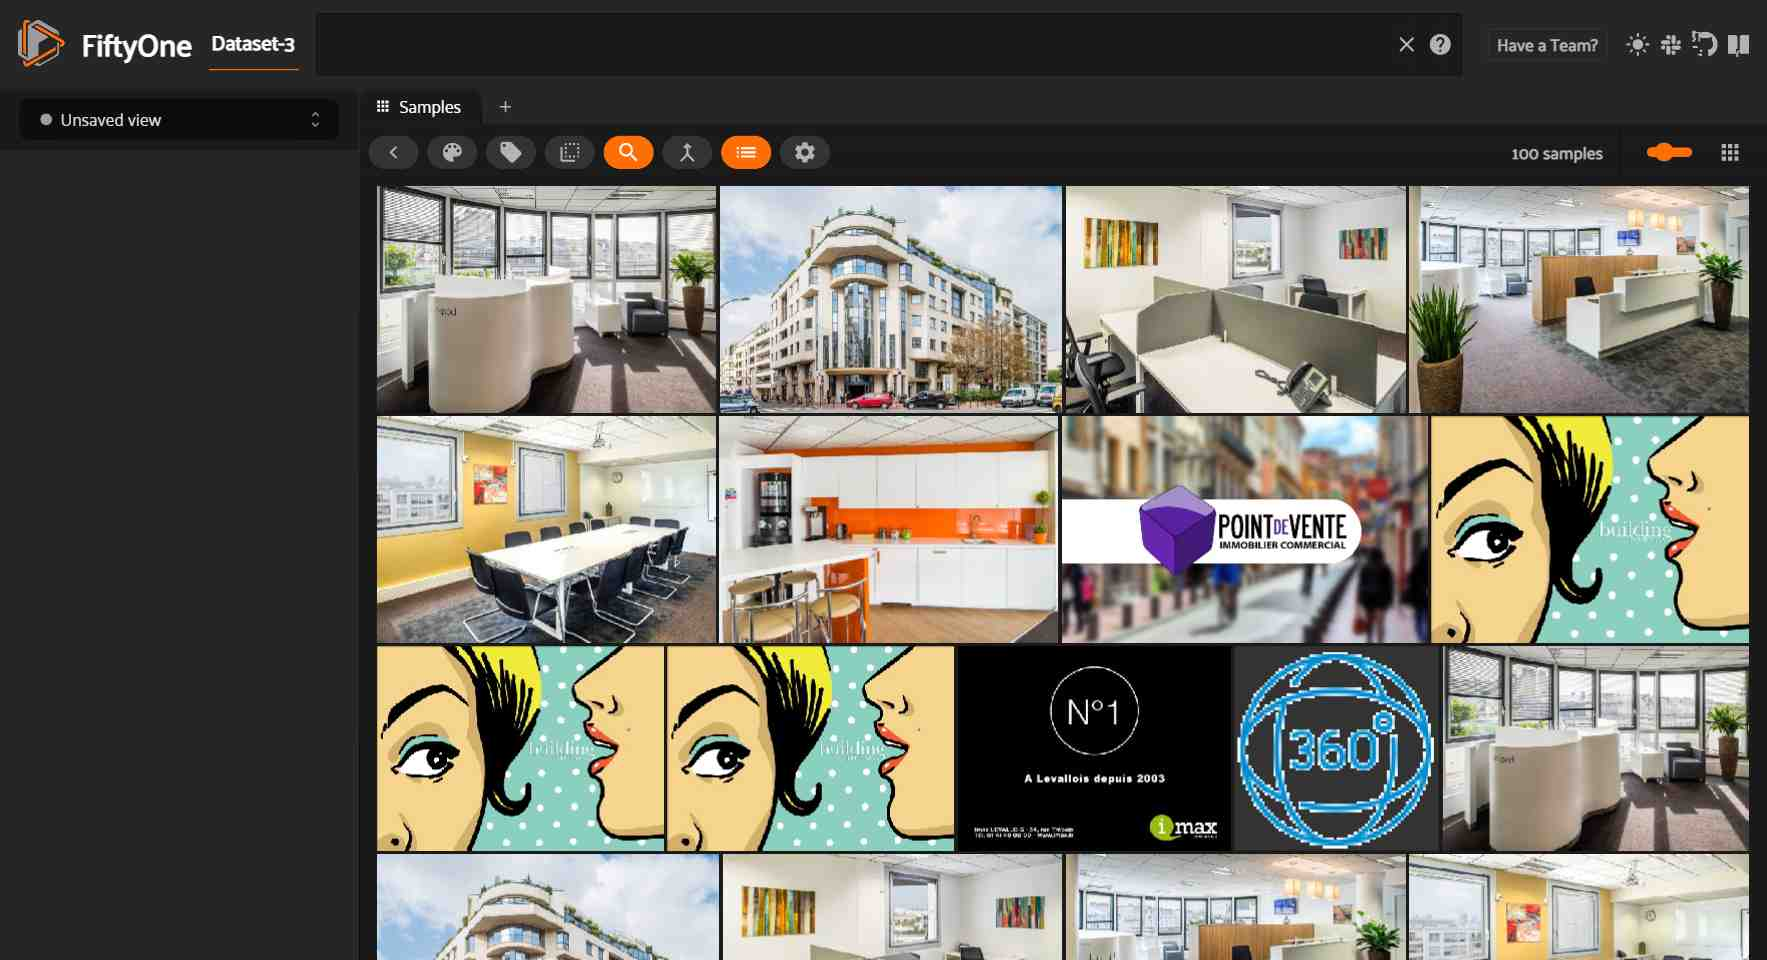


Could not connect session, trying again in 10 seconds



In [ ]:
session.view = dataset.sort_by("uniqueness").limit(100)


In [ ]:

filehash_counts = Counter(sample.file_hash for sample in dataset)
dup_filehashes = [k for k, v in filehash_counts.items() if v > 1]

len(dup_filehashes)

791

In [ ]:
dataset

Name:        Dataset-2
Media type:  image
Num samples: 8682
Persistent:  False
Tags:        []
Sample fields:
    id:        fiftyone.core.fields.ObjectIdField
    filepath:  fiftyone.core.fields.StringField
    tags:      fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    file_hash: fiftyone.core.fields.IntField
    ID:        fiftyone.core.fields.StringField

In [ ]:
dataset.sort_by_similarity(100)


TypeError: 'int' object is not iterable

In [ ]:
def get_id_by_hash(dataset, file_hash):
    ids=[]
    for sample in dataset :
        if sample.file_hash==file_hash:
            ids.append(sample.ID)
            dataset.remove(sample)
    return ids

In [ ]:
duplicates=[]
for sample in tqdm(dataset):
    file_hash = sample.file_hash
    if file_hash in dup_filehashes:
        ids = get_id_by_hash(dataset, file_hash)
        duplicates.append(
            {
                "ID":sample.ID,
                "DUPLICATE_IDS":ids,
                "N_DUPLICATES":len(ids)
            }
        )


  0%|          | 0/8682 [00:00<?, ?it/s]

  0%|          | 16/8682 [00:00<00:09, 885.24it/s]


AttributeError: 'Dataset' object has no attribute 'remove'

In [ ]:


print("Number of duplicate file hashes: %d" % len(dup_filehashes))

dup_view = (dataset
    # Extract samples with duplicate file hashes
    .match(F("file_hash").is_in(dup_filehashes))
    # Sort by file hash so duplicates will be adjacent
    .sort_by("file_hash")
)

print("Number of images that have a duplicate:", len(dup_view))
print("Number of duplicates: ", (len(dup_view) - len(dup_filehashes)))
session = fo.launch_app()
session.view = dup_view

session.wait()

Number of duplicate file hashes: 791
Number of images that have a duplicate: 2055
Number of duplicates:  1264


RuntimeError: Failed to post event `state_update` to http://localhost:5151/event